# Gene expression re-normalization

We need to renormalize gene expression to reduce chrM bias or MYC gene expression amplification bias.

# Outline
- [Introduction](#gene-expression-re-normalization)
- [Setup](#setup)
- [Data](#data)
- [Reproduce problem](#reproduce-chrm-bias)

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
#from depmap_omics_upload import tracker as track

tc = TaigaClient()

# Data

In [2]:
%%capture

OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [3]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape

(1882, 19193)

In [4]:
%%capture

OmicsExpressionAllGenesEffectiveLengthProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesEffectiveLengthProfile')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')
OmicsExpressionGenesExpectedCountProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionGenesExpectedCountProfile')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')


In [5]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

In [6]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape, \
    OmicsExpressionAllGenesEffectiveLengthProfile.shape, \
    OmicsExpressionAllGenesTPMLogp1Profile.shape, \
    OmicsExpressionGenesExpectedCountProfile.shape, \
    OmicsExpressionProteinCodingGenesTPMLogp1.shape

((1882, 19193), (1904, 60605), (1904, 53961), (1904, 54353), (1882, 19193))

In [12]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, OmicsExpressionGenesExpectedCountProfile.columns]

In [13]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.shape, OmicsExpressionGenesExpectedCountProfile.shape

((1904, 54353), (1904, 54353))

# Reproduce TPM for protein coding genes

In [8]:
def calculate_tpm(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape

    denom = counts_df.sum(axis=1)
    denom = denom.where(denom > 1e-300, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > 1e-300, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > 1e-300, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [15]:
OmicsExpressionGenesExpectedCountProfile_tpm = calculate_tpm(OmicsExpressionGenesExpectedCountProfile, OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)

0
0
0
0
0


In [7]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)

downloading gene names from biomart


In [8]:
protcod_rename = {}
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )

In [9]:
protcod_rename.keys()

dict_keys(['MT-ND1 (ENSG00000198888)', 'MT-ND2 (ENSG00000198763)', 'MT-CO1 (ENSG00000198804)', 'MT-CO2 (ENSG00000198712)', 'MT-ATP8 (ENSG00000228253)', 'MT-ATP6 (ENSG00000198899)', 'MT-CO3 (ENSG00000198938)', 'MT-ND3 (ENSG00000198840)', 'MT-ND4L (ENSG00000212907)', 'MT-ND4 (ENSG00000198886)', 'MT-ND5 (ENSG00000198786)', 'MT-ND6 (ENSG00000198695)', 'MT-CYB (ENSG00000198727)', 'AC240274.1 (ENSG00000271254)', 'OPRL1 (ENSG00000277044)', 'NPBWR2 (ENSG00000277339)', 'MYT1 (ENSG00000276876)', 'PCMTD2 (ENSG00000280663)', 'KIR3DL3 (ENSG00000275433)', 'KIR2DL3 (ENSG00000273947)', 'KIR2DL1 (ENSG00000273510)', 'KIR2DL4 (ENSG00000276779)', 'KIR3DL1 (ENSG00000278079)', 'KIR3DL3 (ENSG00000274696)', 'KIR2DL3 (ENSG00000277484)', 'KIR2DS4 (ENSG00000273526)', 'KIR2DL1 (ENSG00000274782)', 'KIR3DL2 (ENSG00000275416)', 'KIR2DL4 (ENSG00000274955)', 'FCAR (ENSG00000273738)', 'KIR3DL1 (ENSG00000276379)', 'NCR1 (ENSG00000275637)', 'KIR3DL3 (ENSG00000277028)', 'SNTG2 (ENSG00000281486)', 'KIR2DL3 (ENSG00000273887

In [19]:
OmicsExpressionGenesExpectedCountProfile_tpm.columns = OmicsExpressionGenesExpectedCountProfile_tpm.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm.columns.isnull()]

In [20]:
OmicsExpressionAllGenesTPMLogp1Profile.columns = OmicsExpressionAllGenesTPMLogp1Profile.columns.map(protcod_rename)
OmicsExpressionAllGenesTPMLogp1Profile = OmicsExpressionAllGenesTPMLogp1Profile.loc[:, ~OmicsExpressionAllGenesTPMLogp1Profile.columns.isnull()]

In [21]:
from scipy.stats import pearsonr

tpm_correlation_list = []
for gene in OmicsExpressionAllGenesTPMLogp1Profile.columns:
    tpm_correlation_list.append(pearsonr(OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, gene], OmicsExpressionAllGenesTPMLogp1Profile.loc[:, gene])[0])

In [22]:
np.isnan(tpm_correlation_list).sum(), np.min(tpm_correlation_list), np.mean(tpm_correlation_list)

(0, 0.856137599505253, 0.9998655014281763)

<Axes: ylabel='Density'>

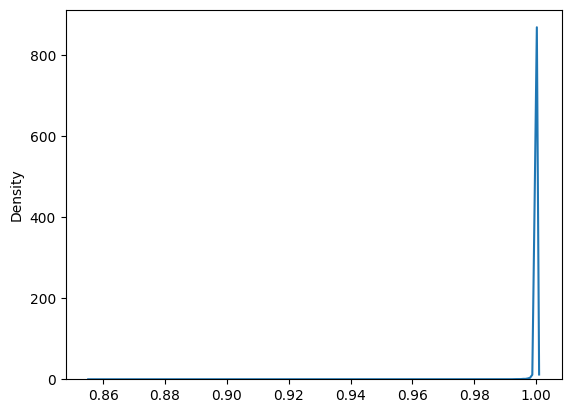

In [23]:
sns.kdeplot(tpm_correlation_list)

In [24]:
OmicsExpressionGenesExpectedCountProfile_tpm.isnull().sum().sum()

0

In [25]:
OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountModel_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [26]:
OmicsExpressionGenesExpectedCountProfile_tpm.shape

(1904, 19194)

# Reproduce chrM bias

In [27]:
sample_median_expression = OmicsExpressionProteinCodingGenesTPMLogp1.median(axis=1)
sample_median_expression_rank = sample_median_expression.rank()

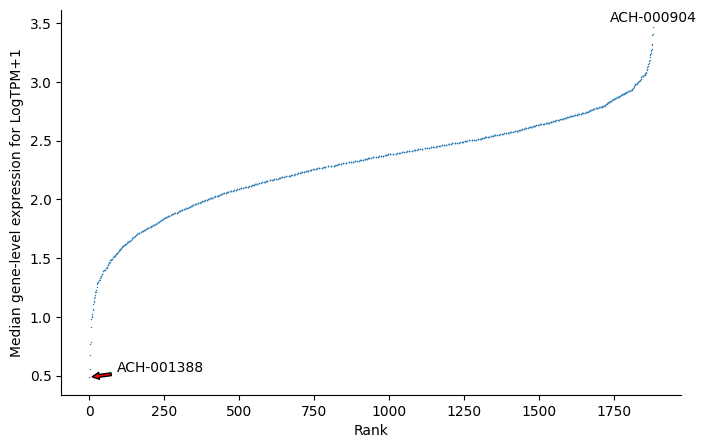

In [28]:
top_1_sample_index = sample_median_expression.argmax()
top_1_sample_rank = sample_median_expression_rank[top_1_sample_index]
top_1_sample = sample_median_expression.index[top_1_sample_index]
top_1_sample_expression = sample_median_expression[top_1_sample_index]
bottom_1_sample_index = sample_median_expression.argmin()
bottom_1_sample_rank = sample_median_expression_rank[bottom_1_sample_index]
bottom_1_sample = sample_median_expression.index[bottom_1_sample_index]
bottom_1_sample_expression = sample_median_expression[bottom_1_sample_index]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.scatterplot(y=sample_median_expression, x=sample_median_expression_rank, ax=ax, s=1)
ax.set_xlabel("Rank")
ax.set_ylabel("Median gene-level expression for LogTPM+1")
ax.annotate(top_1_sample, xy=(top_1_sample_rank, top_1_sample_expression), xytext=(0, 2), ha='center', textcoords='offset points', va='bottom')
ax.annotate(bottom_1_sample, xy=(bottom_1_sample_rank, bottom_1_sample_expression), 
            xytext=(bottom_1_sample_rank+50, 2), ha='center', va='bottom', textcoords='offset points', 
                arrowprops = dict(arrowstyle="simple", facecolor='red'))

sns.despine()

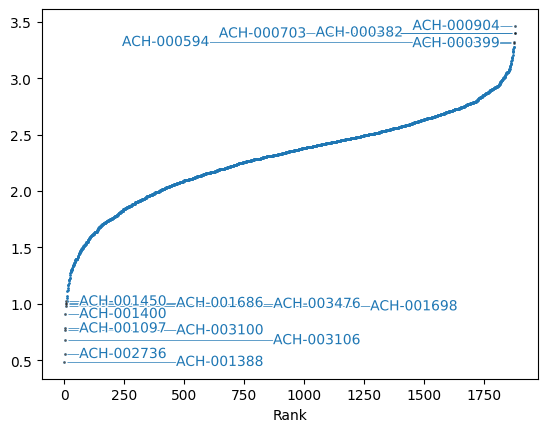

In [29]:
plotting.waterfall_plot(sample_median_expression, s=1)

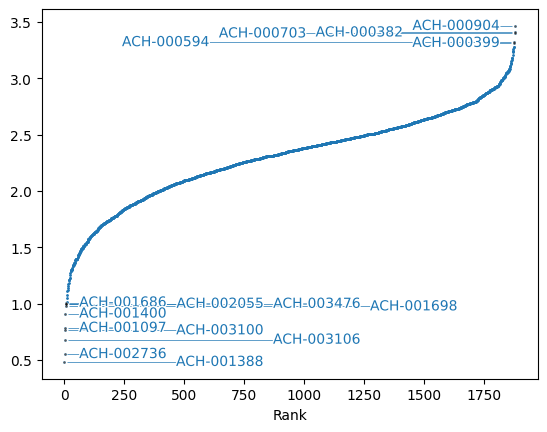

In [30]:
new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

In [31]:
new_sample_median_expression.head()

ACH-001113    2.577495
ACH-001289    2.433611
ACH-001339    2.251976
ACH-001979    1.856811
ACH-002438    2.345780
dtype: float64

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


(0.0, 18.0)

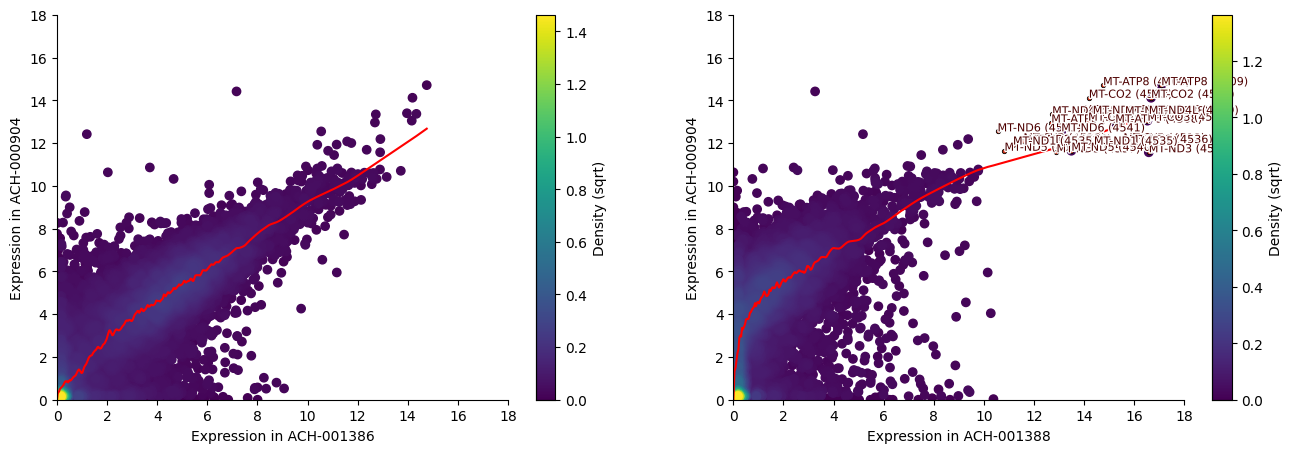

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionProteinCodingGenesTPMLogp1.columns[OmicsExpressionProteinCodingGenesTPMLogp1.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-001386', :]
lowest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-001388', :]
lowest_sample = OmicsExpressionProteinCodingGenesTPMLogp1.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

(0.0, 18.0)

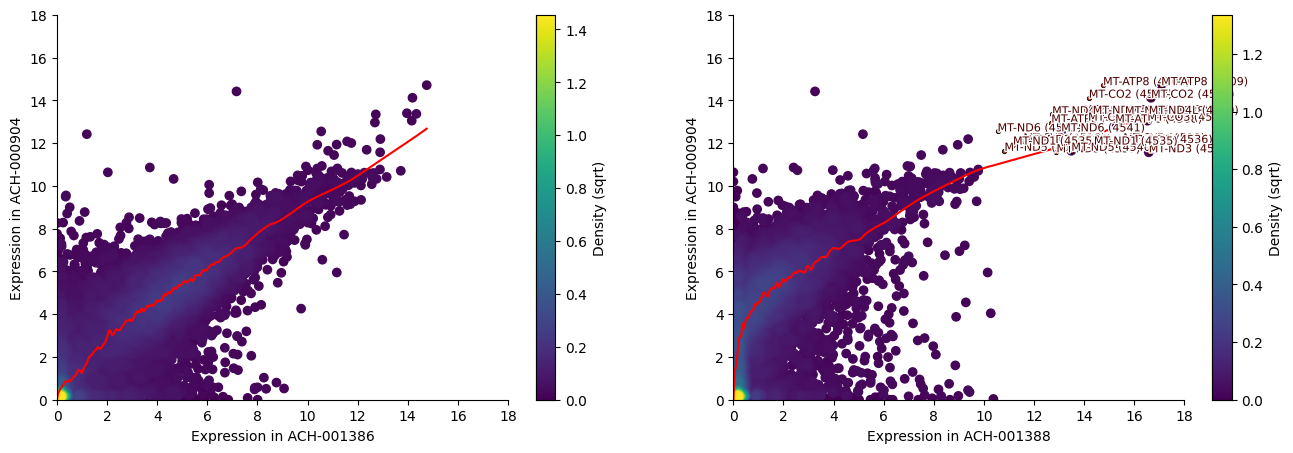

In [33]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001386', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

Text(0.5, 0, 'All gene median expression')

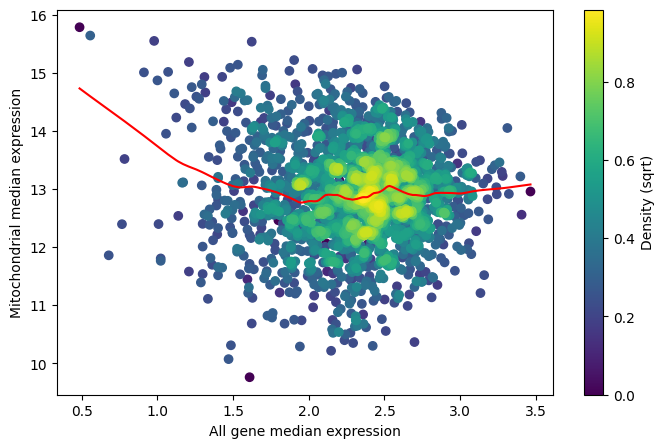

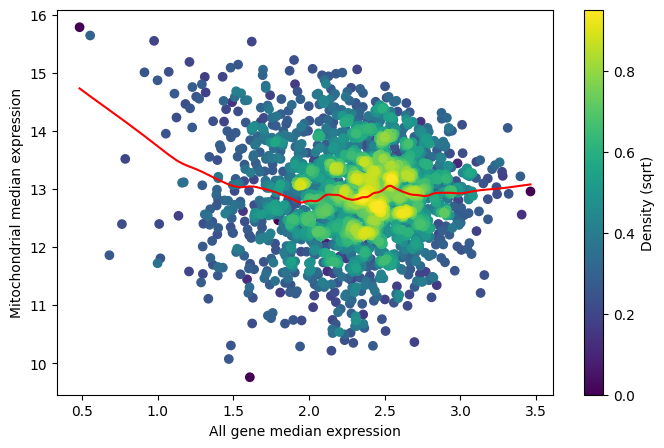

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, :].median(axis=1),
                         OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

# Apply the correction

In [38]:
def calculate_tpm_correct_chrM_log(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [36]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM_log(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


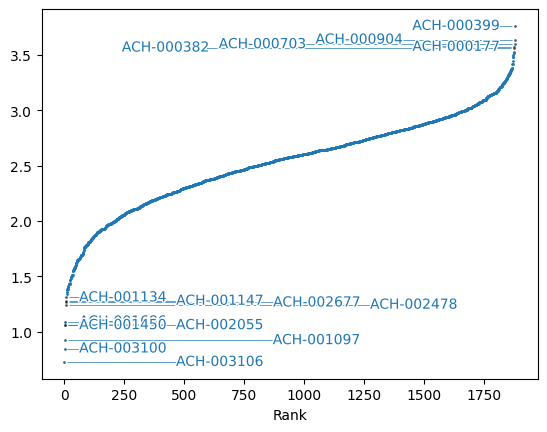

In [37]:
new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm_chrM.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

Text(0.5, 0, 'All gene median expression')

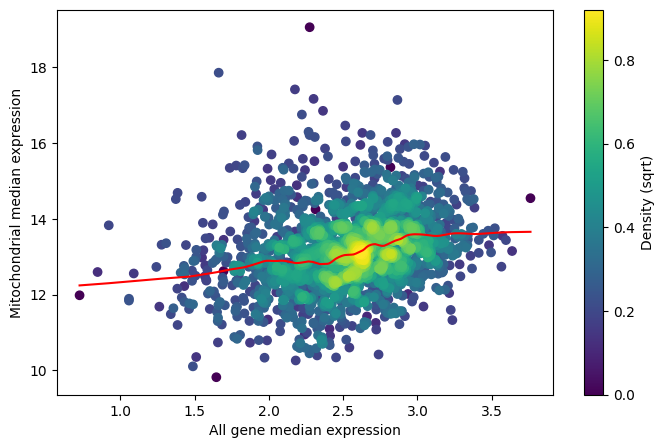

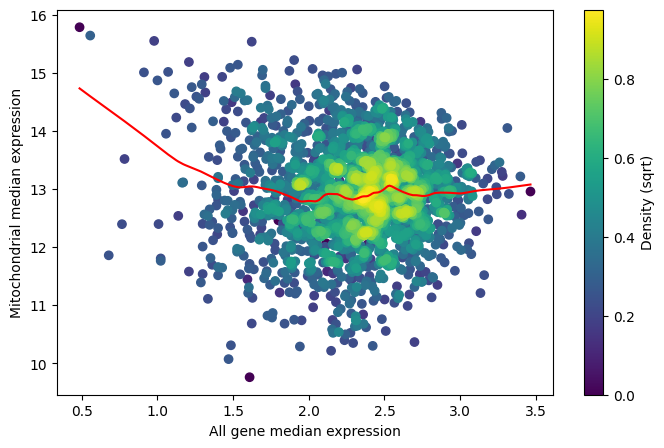

In [38]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

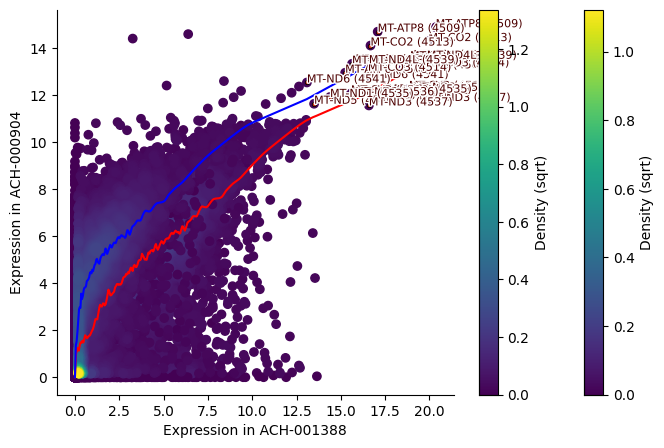

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-000904')

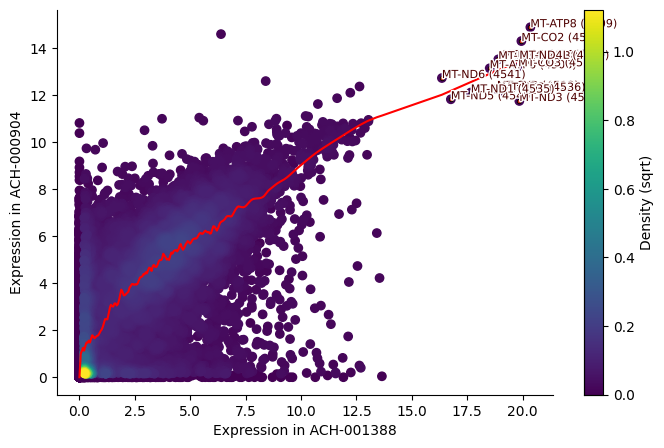

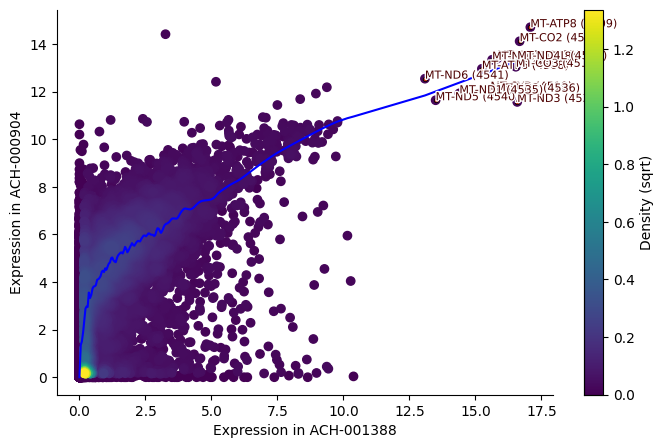

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-003106')

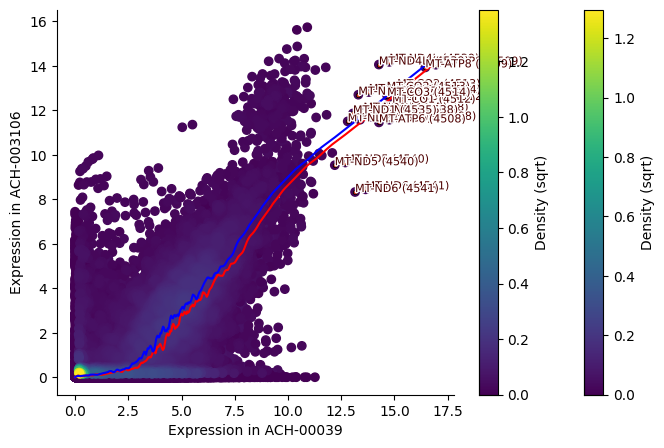

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000399', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-003106', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-00039")
ax.set_ylabel("Expression in ACH-003106")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000399', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-003106', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-00039")
ax.set_ylabel("Expression in ACH-003106")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

## Upload this new version of datasets

In [42]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv")

In [43]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-8a6b",
        changes_description="post 23Q4 adjust gene expression normalization 2",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 3.
Linking virtual file OmicsExpressionGenesExpectedCountModel_tpm_chrM
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/cc3e017b99e2400a86479d2d2828ddc3


'cc3e017b99e2400a86479d2d2828ddc3'

# Square root normalization

In [54]:
def calculate_tpm_correct_chrM(counts_df, transcripts_length_df, chrM=True):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    if chrM:
        denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    else:
        denom = counts_df.sum(axis=1)

    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    if chrM:
        fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    else:
        fpkm_sum = fpkm.sum(axis=1)

    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.sqrt(tpm_df+1)

In [55]:
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes, chrM=False)
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_sqrt = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_sqrt = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


In [56]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


Text(0.5, 0, 'All gene median expression')

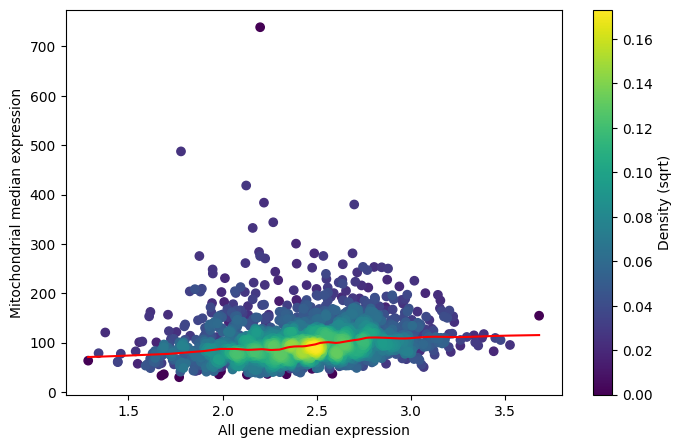

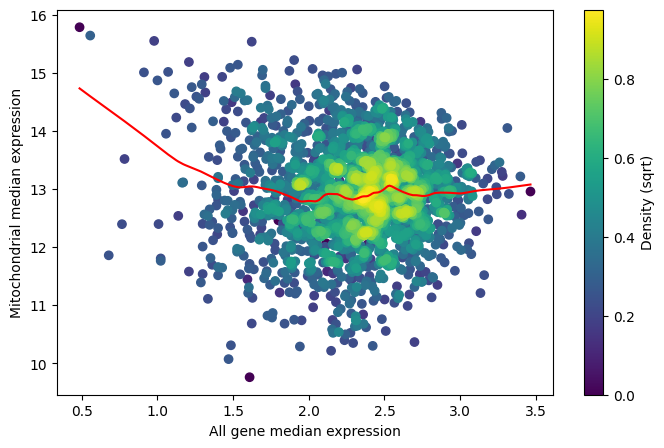

In [57]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns[OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")
#ax.set_ylim(0, 200)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

Text(0.5, 0, 'All gene median expression')

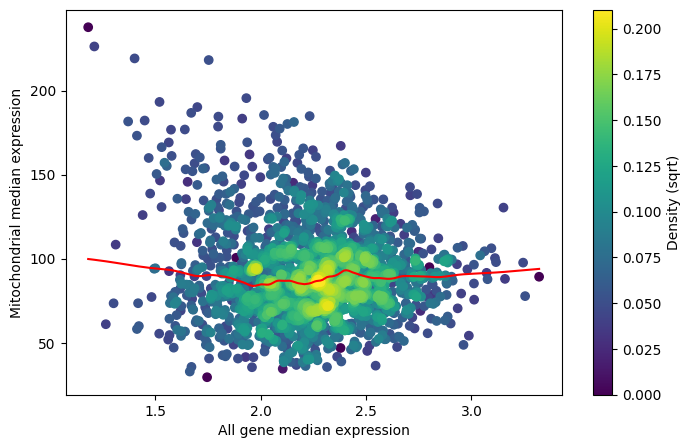

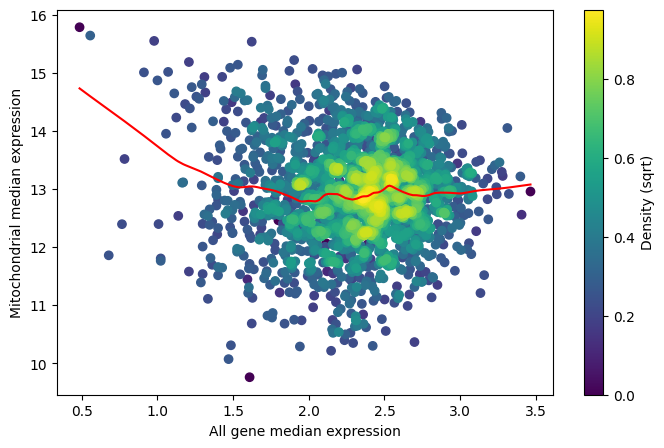

In [62]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.columns[OmicsExpressionGenesExpectedCountModel_tpm_sqrt.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")
#ax.set_ylim(0, 200)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

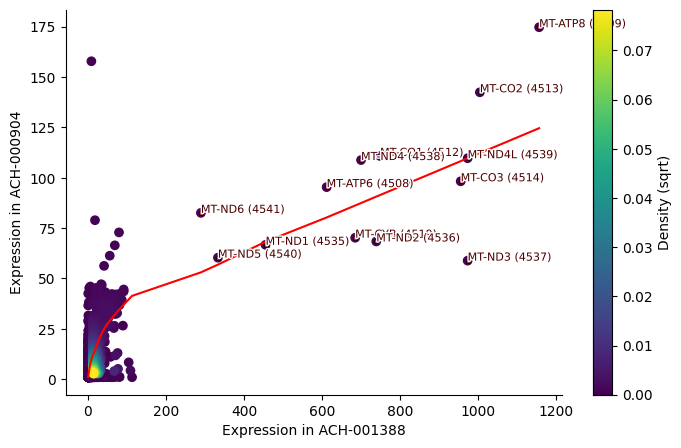

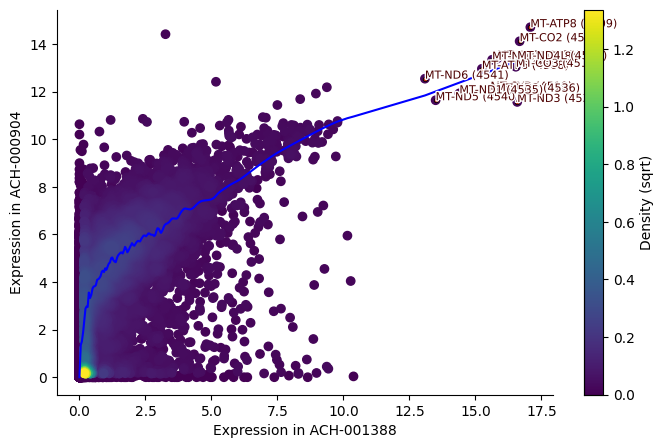

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-000904')

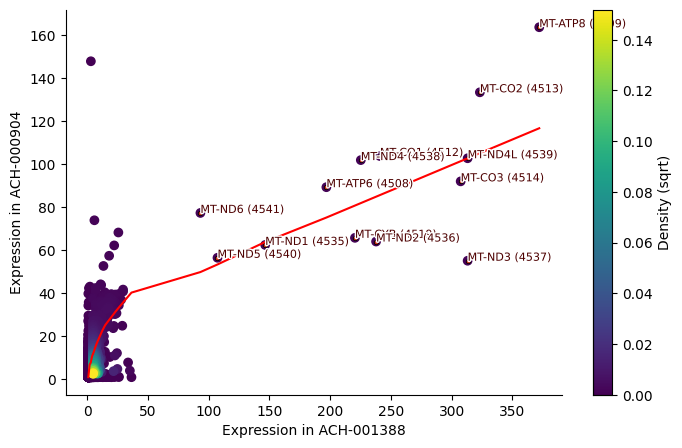

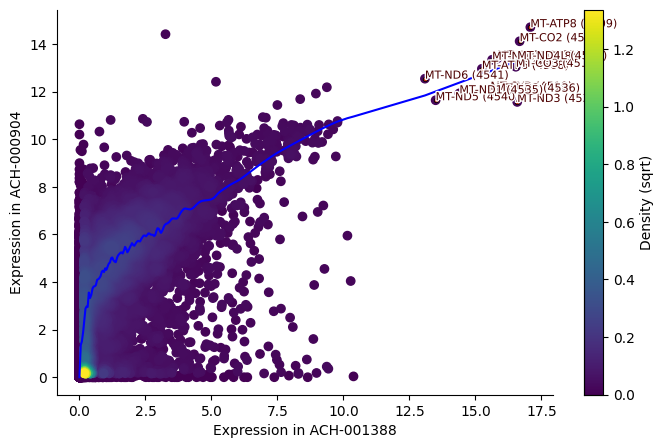

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

In [63]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv")

In [68]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
        changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM-sqrt",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 3.
Linking virtual file OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/57cac9b7bfc846f49d8684ff3c4fa7ba


'57cac9b7bfc846f49d8684ff3c4fa7ba'

In [65]:
OmicsExpressionGenesExpectedCountModel_tpm_sqrt.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_sqrt.csv")

In [67]:
update = False
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
        changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-sqrt",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_sqrt.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_sqrt", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

Uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to S3
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to S3
Uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to Taiga
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/7977896460ef4f829ee5da134160732c



'7977896460ef4f829ee5da134160732c'

# Aggregate read count table for testing

In [10]:
import pandas as pd
import dalmatian as dm

In [11]:
wm = dm.WorkspaceManager("broad-firecloud-ccle/DepMap_hg38_RNAseq")
terra_rnaseq_df = wm.get_samples()

In [12]:
def load_rnaseqc(terra_path):
    rnaseqc_count_df = pd.read_csv(terra_path, sep='\t', skiprows=2)
    rnaseqc_count_df = rnaseqc_count_df.set_index(rnaseqc_count_df.apply(lambda x: f"{x[1]} ({x[0].split('.')[0]})", axis=1))
    rnaseqc_count_df = rnaseqc_count_df.drop(["Name", "Description"], axis=1)
    return rnaseqc_count_df

In [13]:
from multiprocessing import Pool
pool = Pool(12)
rnaseqc_count_dfs = pool.map(load_rnaseqc, terra_rnaseq_df.rnaseqc2_gene_counts)

In [14]:
pool.close()

In [15]:
rnaseqc_count_mat = pd.concat(rnaseqc_count_dfs, axis=1)

In [16]:
rnaseqc_count_mat = rnaseqc_count_mat.T

In [18]:
rnaseqc_count_mat.shape

(2222, 57975)

In [19]:
rnaseqc_count_mat.head()

DDX11L1 (ENSG00000223972)  WASH7P (ENSG00000227232)  \
CDS-010xbm                          0                       193   
CDS-02TzJp                          0                       108   
CDS-04NSe4                          0                        47   
CDS-0693hw                          0                       179   
CDS-07Plat                          1                       184   

            MIR6859-1 (ENSG00000278267)  MIR1302-2HG (ENSG00000243485)  \
CDS-010xbm                            0                              0   
CDS-02TzJp                            0                              4   
CDS-04NSe4                            0                              0   
CDS-0693hw                            0                              1   
CDS-07Plat                            0                              0   

            MIR1302-2 (ENSG00000284332)  FAM138A (ENSG00000237613)  \
CDS-010xbm                            0                          0   
CDS-02TzJp                            1                          0   
CDS-04NSe4                            0                          0   
CDS-0693hw                            0                          1   
CDS-07Plat                            0                          0   

            OR4G4P (ENSG00000268020)  OR4G11P (ENSG00000240361)  \
CDS-010xbm                         0                          0   
CDS-02TzJp                         0                          1   
CDS-04NSe4                         2                          1   
CDS-0693hw                         2                          3   
CDS-07Plat                         0                          1   

            OR4F5 (ENSG00000186092)  AL627309.1 (ENSG00000238009)  ...  \
CDS-010xbm                        0                            15  ...   
CDS-02TzJp                        2                             7  ...   
CDS-04NSe4                        4                             3  ...   
CDS-0693hw                        3                             8  ...   
CDS-07Plat                        0                             1  ...   

            ERCC-00157 (ERCC-00157)  ERCC-00158 (ERCC-00158)  \
CDS-010xbm                        0                        0   
CDS-02TzJp                        0                        0   
CDS-04NSe4                       28                        0   
CDS-0693hw                       20                        2   
CDS-07Plat                       52                        2   

            ERCC-00160 (ERCC-00160)  ERCC-00162 (ERCC-00162)  \
CDS-010xbm                        4                       88   
CDS-02TzJp                        0                        0   
CDS-04NSe4                       50                      336   
CDS-0693hw                       24                      357   
CDS-07Plat                       38                      346   

            ERCC-00163 (ERCC-00163)  ERCC-00164 (ERCC-00164)  \
CDS-010xbm                       16                        0   
CDS-02TzJp                        0                        0   
CDS-04NSe4                       83                        0   
CDS-0693hw                       67                        0   
CDS-07Plat                      119                        0   

            ERCC-00165 (ERCC-00165)  ERCC-00168 (ERCC-00168)  \
CDS-010xbm                       26                        2   
CDS-02TzJp                        0                        0   
CDS-04NSe4                      224                        0   
CDS-0693hw                      127                        4   
CDS-07Plat                       97                        4   

            ERCC-00170 (ERCC-00170)  ERCC-00171 (ERCC-00171)  
CDS-010xbm                       16                     2177  
CDS-02TzJp                        0                        0  
CDS-04NSe4                      139                    11623  
CDS-0693hw                       65                    11630  
CDS-07Plat                       85     

In [20]:
##all_samples_qc = tc.get(name='expression-869e', version=6, file='all_samples_qc')
all_samples_qc = tc.get(name='expression-d035', version=44, file='all_samples_qc')

[                      ]  0% |   0.0 s/B |   0.0 B / 642.3 KiB | ETA:  --:--:--
[##################]100% | 580.3 MiB/s | 642.3 KiB / 642.3 KiB | ETA:  00:00:00


In [21]:
all_samples_qc.head()

Mapping Rate  Unique Rate of Mapped  Duplicate Rate of Mapped  \
CDS-010xbm      0.995060                    1.0                       0.0   
CDS-02TzJp      0.990214                    1.0                       0.0   
CDS-04NSe4      0.988511                    1.0                       0.0   
CDS-0693hw      0.989382                    1.0                       0.0   
CDS-07Plat      0.994575                    1.0                       0.0   

            Duplicate Rate of Mapped, excluding Globins  Base Mismatch  \
CDS-010xbm                                          0.0       0.007751   
CDS-02TzJp                                          0.0       0.002915   
CDS-04NSe4                                          0.0       0.004122   
CDS-0693hw                                          0.0       0.003719   
CDS-07Plat                                          0.0       0.002803   

            End 1 Mapping Rate  End 2 Mapping Rate  End 1 Mismatch Rate  \
CDS-010xbm            0.995549            0.994570             0.012184   
CDS-02TzJp            0.991692            0.988737             0.002827   
CDS-04NSe4            0.993191            0.983831             0.002112   
CDS-0693hw            0.990809            0.987954             0.003554   
CDS-07Plat            0.995558            0.993592             0.003149   

            End 2 Mismatch Rate  Expression Profiling Efficiency  ...  \
CDS-010xbm             0.003314                         0.819752  ...   
CDS-02TzJp             0.003003                         0.926890  ...   
CDS-04NSe4             0.006150                         0.935062  ...   
CDS-0693hw             0.003885                         0.932386  ...   
CDS-07Plat             0.002456                         0.921268  ...   

            Median 3' bias  3' bias Std  3' bias MAD_Std  \
CDS-010xbm        0.400000     0.301578         0.375960   
CDS-02TzJp        0.472222     0.311115         0.411833   
CDS-04NSe4        0.500000     0.302226         0.375920   
CDS-0693hw        0.518519     0.317015         0.426617   
CDS-07Plat        0.640000     0.310184         0.382450   

            3' Bias, 25th Percentile  3' Bias, 75th Percentile  \
CDS-010xbm                  0.165079                  0.687500   
CDS-02TzJp                  0.200000                  0.750000   
CDS-04NSe4                  0.247126                  0.754717   
CDS-0693hw                  0.230769                  0.807882   
CDS-07Plat                  0.331821                  0.866667   

            Median of Avg Transcript Coverage  \
CDS-010xbm                            3.62379   
CDS-02TzJp                            1.89753   
CDS-04NSe4                            1.61595   
CDS-0693hw                            2.76970   
CDS-07Plat                            1.46290   

            Median of Transcript Coverage Std  \
CDS-010xbm                            3.07969   
CDS-02TzJp                            1.81705   
CDS-04NSe4                            1.99344   
CDS-0693hw                            2.50198   
CDS-07Plat                            1.83251   

            Median of Transcript Coverage CV  Median Exon CV  Exon CV MAD  
CDS-010xbm                          0.858657        0.191796     0.187748  
CDS-02TzJp                          0.902930        0.182033     0.183706  
CDS-04NSe4                          0.963209        0.156832     0.165194  
CDS-0693hw                          0.947570        0.184603     0.188875  
CDS-07Plat                          1.084040        0.255671     0.249792  

[5 rows x 77 columns]

In [22]:
rnaseqc_count_mat.to_csv("rnaseqc_count_mat.csv")

In [23]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="rnqseqc2-gene-count-profile-5577",
        changes_description="rnqseqc2 count cds ids",
        upload_files=[
            {
                "path": "rnaseqc_count_mat.csv",
                "name": "rnqseqc2_gene_count_profile", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="rnqseqc2 count profile",
   )
else:
   new_dataset_id = tc.create_dataset(
       "rnqseqc2_gene_count_profile",
       dataset_description="rnqseqc2 count profile",
       upload_files=[
           {
               "path": "rnaseqc_count_mat.csv",
               "name": "rnqseqc2_gene_count_profile", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 1.
Finished uploading rnqseqc2_gene_count_profile to S3
Uploading rnqseqc2_gene_count_profile to Taiga
Finished uploading rnqseqc2_gene_count_profile to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/330bc85b750e44f783f6afa19f27304c


'330bc85b750e44f783f6afa19f27304c'

In [24]:
import pickle
with open("/home/ubuntu/pr_table.pkl", "rb") as input_file:
    pr_dict = pickle.load(input_file)

In [25]:
rnaseqc_count_mat.index = rnaseqc_count_mat.index.map(pr_dict)

In [26]:
all_samples_qc.shape

(2222, 77)

In [27]:
rnaseqc_count_mat.shape

(2222, 57975)

In [28]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[~rnaseqc_count_mat.index.isnull(), :]

In [29]:
rnaseqc_count_mat.shape

(2152, 57975)

In [30]:
rnaseqc_count_lengths = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, np.intersect1d(rnaseqc_count_mat.columns, OmicsExpressionAllGenesEffectiveLengthProfile.columns)]

In [31]:
rnaseqc_count_mat.shape, rnaseqc_count_lengths.shape

((2152, 57975), (1904, 52101))

In [32]:
rnaseqc_count_lengths = rnaseqc_count_lengths.loc[np.intersect1d(rnaseqc_count_mat.index, rnaseqc_count_lengths.index), :]

In [33]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[rnaseqc_count_lengths.index, :]

In [34]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[:, rnaseqc_count_lengths.columns]

In [35]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[:, ~rnaseqc_count_mat.columns.duplicated()]

In [36]:
rnaseqc_count_mat.shape, rnaseqc_count_lengths.shape

((1904, 52101), (1904, 52101))

In [39]:
rnaseqc_count_mat_tpm = calculate_tpm_correct_chrM_log(rnaseqc_count_mat, rnaseqc_count_lengths)

37
0
0
0
0
0


In [40]:
rnaseqc_count_mat_tpm.head()

A1BG (ENSG00000121410)  A1BG-AS1 (ENSG00000268895)  \
PR-01r7OM                0.059474                    0.401435   
PR-02XmLG                2.254326                    2.542253   
PR-045poV                2.304418                    2.936978   
PR-09gmEI                5.185779                    1.906509   
PR-0B6q0Z                0.087784                    0.293352   

           A1CF (ENSG00000148584)  A2M (ENSG00000175899)  \
PR-01r7OM                0.705947               0.182850   
PR-02XmLG                0.000000               2.275013   
PR-045poV                0.000000               0.043214   
PR-09gmEI                0.016845               0.506588   
PR-0B6q0Z                0.108657               0.032893   

           A2M-AS1 (ENSG00000245105)  A2ML1 (ENSG00000166535)  \
PR-01r7OM                   0.212230                 0.015394   
PR-02XmLG                   0.419993                 0.000000   
PR-045poV                   0.674637                 0.057505   
PR-09gmEI                   0.167469                 0.107591   
PR-0B6q0Z                   0.359153                 0.015455   

           A2ML1-AS1 (ENSG00000256661)  A2ML1-AS2 (ENSG00000256904)  \
PR-01r7OM                     0.076179                          0.0   
PR-02XmLG                     0.000000                          0.0   
PR-045poV                     0.000000                          0.0   
PR-09gmEI                     0.823610                          0.0   
PR-0B6q0Z                     0.966463                          0.0   

           A2MP1 (ENSG00000256069)  A3GALT2 (ENSG00000184389)  ...  \
PR-01r7OM                 0.000000                   0.020783  ...   
PR-02XmLG                 0.000000                   0.000000  ...   
PR-045poV                 0.009764                   0.096937  ...   
PR-09gmEI                 0.043514                   0.067417  ...   
PR-0B6q0Z                 0.000000                   0.123500  ...   

           ZWINT (ENSG00000122952)  ZXDA (ENSG00000198205)  \
PR-01r7OM                 7.005487                0.872316   
PR-02XmLG                 6.965200                0.855300   
PR-045poV                 5.247536                0.017013   
PR-09gmEI                 6.175759                0.648464   
PR-0B6q0Z                 8.060430                0.532327   

           ZXDB (ENSG00000198455)  ZXDC (ENSG00000070476)  \
PR-01r7OM                2.094132                3.260706   
PR-02XmLG                2.821624                2.976353   
PR-045poV                2.792961                3.131079   
PR-09gmEI                1.993348                3.284161   
PR-0B6q0Z                1.604463                2.697180   

           ZYG11A (ENSG00000203995)  ZYG11AP1 (ENSG00000232242)  \
PR-01r7OM                  0.026600                         0.0   
PR-02XmLG                  0.019210                         0.0   
PR-045poV                  0.640601                         0.0   
PR-09gmEI                  2.570536                         0.0   
PR-0B6q0Z                  1.936875                         0.0   

           ZYG11B (ENSG00000162378)  ZYX (ENSG00000159840)  \
PR-01r7OM                  2.555288               7.613109   
PR-02XmLG                  4.258689               6.609216   
PR-045poV                  3.018666               6.712198   
PR-09gmEI                  3.284687               7.383111   
PR-0B6q0Z                  2.638723               7.154111   

           ZYXP1 (ENSG00000274572)  ZZEF1 (ENSG00000074755)  
PR-01r7OM                      0.0                 3.563383  
PR-02XmLG                      0.0                 3.028689  
PR-045poV                      0.0                 3.381476  
PR-09gmEI                      0.0                 3.055198  
PR-0B6q0Z                      0.0                 2.907798  

[5 rows x 52101 columns]

In [41]:
rnaseqc_count_mat_tpm.columns = rnaseqc_count_mat_tpm.columns.map(protcod_rename)
rnaseqc_count_mat_tpm = rnaseqc_count_mat_tpm.loc[:, ~rnaseqc_count_mat_tpm.columns.isnull()]

In [42]:
rnaseqc_count_mat_tpm.shape

(1904, 18794)

In [43]:
rnaseqc_count_mat_tpm.index = rnaseqc_count_mat_tpm.index.map(profile_to_model_dict)

In [44]:
rnaseqc_count_mat_tpm.shape

(1904, 18794)

In [45]:
rnaseqc_count_mat_tpm = rnaseqc_count_mat_tpm.loc[~rnaseqc_count_mat_tpm.index.isnull(), :]

In [46]:
rnaseqc_count_mat_tpm.shape, OmicsExpressionProteinCodingGenesTPMLogp1.shape

((1882, 18794), (1882, 19193))

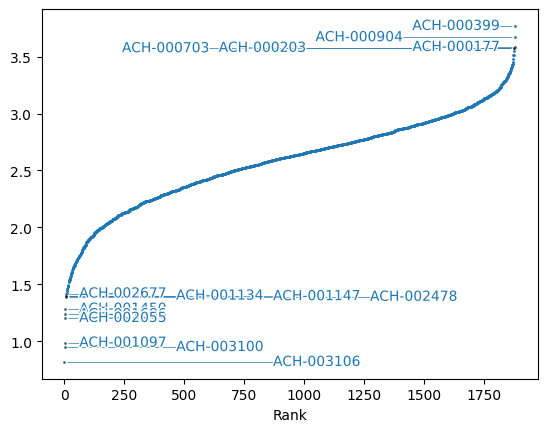

In [47]:
new_sample_median_expression = rnaseqc_count_mat_tpm.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

Text(0.5, 0, 'All gene median expression')

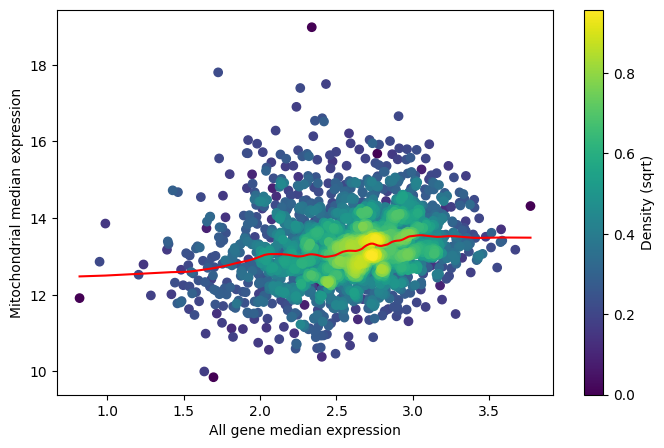

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
chrM_labels = rnaseqc_count_mat_tpm.columns[rnaseqc_count_mat_tpm.columns.str.contains("^MT-")]

plotting.density_scatter(rnaseqc_count_mat_tpm.loc[:, :].median(axis=1),
                         rnaseqc_count_mat_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


(0.0, 18.0)

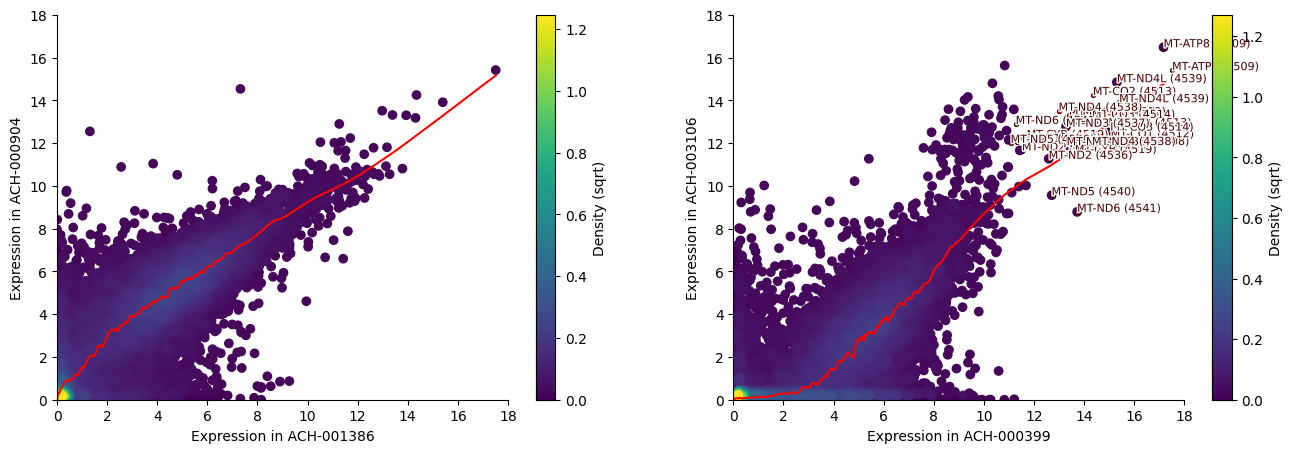

In [49]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = rnaseqc_count_mat_tpm.columns[rnaseqc_count_mat_tpm.columns.str.contains("^MT-")]
highest_sample = rnaseqc_count_mat_tpm.loc['ACH-001386', :]
lowest_sample = rnaseqc_count_mat_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)


highest_sample = rnaseqc_count_mat_tpm.loc['ACH-000399', :]
lowest_sample = rnaseqc_count_mat_tpm.loc['ACH-003106', :]

plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-000399")
ax[1].set_ylabel("Expression in ACH-003106")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)